In [173]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
#from community_layout.layout_class import CommunityLayout

In [28]:
obs = pd.read_excel("dataDU.xlsx", sheet_name="observed")
rand = pd.read_excel("dataDU.xlsx", sheet_name="random")
tags = pd.read_excel("dataDU.xlsx", sheet_name="tags")

C:\Users\majko\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [101]:
def df_matrix_cleaner(df):
    df_clean = []
    matrix = np.zeros([tags.shape[0], tags.shape[0]])

    for i, j in enumerate(tags["tag"]):
        for l, k in enumerate(tags["tag"][i+1:]):
            suma = (df.loc[(df['Tag1'] == j) & (df["Tag2"] == k)]["duration_frames"].sum() + 
                    df.loc[(df['Tag1'] == k) & (df["Tag2"] == j)]["duration_frames"].sum())
            if suma > 0:
                df_clean.append([j, k, suma])
                matrix[i,l+i+1] = suma
                matrix[l+i+1,i] = suma
                
    df_clean = pd.DataFrame(df_clean, columns=["Tag1", "Tag2", "duration_frames"])
    
    return df_clean, matrix

In [102]:
obs_clean, obs_mat = df_matrix_cleaner(obs)

In [110]:
rand_clean, rand_mat = df_matrix_cleaner(rand)

### Priprava grafov

In [136]:
G_obs = nx.from_pandas_edgelist(obs_clean, source='Tag1', target='Tag2',
                            edge_attr='duration_frames')

cols_o = []

for node in G_obs:
    tag = tags.loc[tags["tag"] == node]["task_group"] 
    if (tag == "nurse").all():
        cols_o.append("lightblue")
    elif (tag == "forager").all():
        cols_o.append("orange")
    elif (tag == "queen").all():
        cols_o.append("green")
        
G_rand = nx.from_pandas_edgelist(rand_clean, source='Tag1', target='Tag2',
                            edge_attr='duration_frames')

cols_r = []

for node in G_rand:
    tag = tags.loc[tags["tag"] == node]["task_group"] 
    if (tag == "nurse").all():
        cols_r.append("lightblue")
    elif (tag == "forager").all():
        cols_r.append("orange")
    elif (tag == "queen").all():
        cols_r.append("green")

### Kreslenie grafov

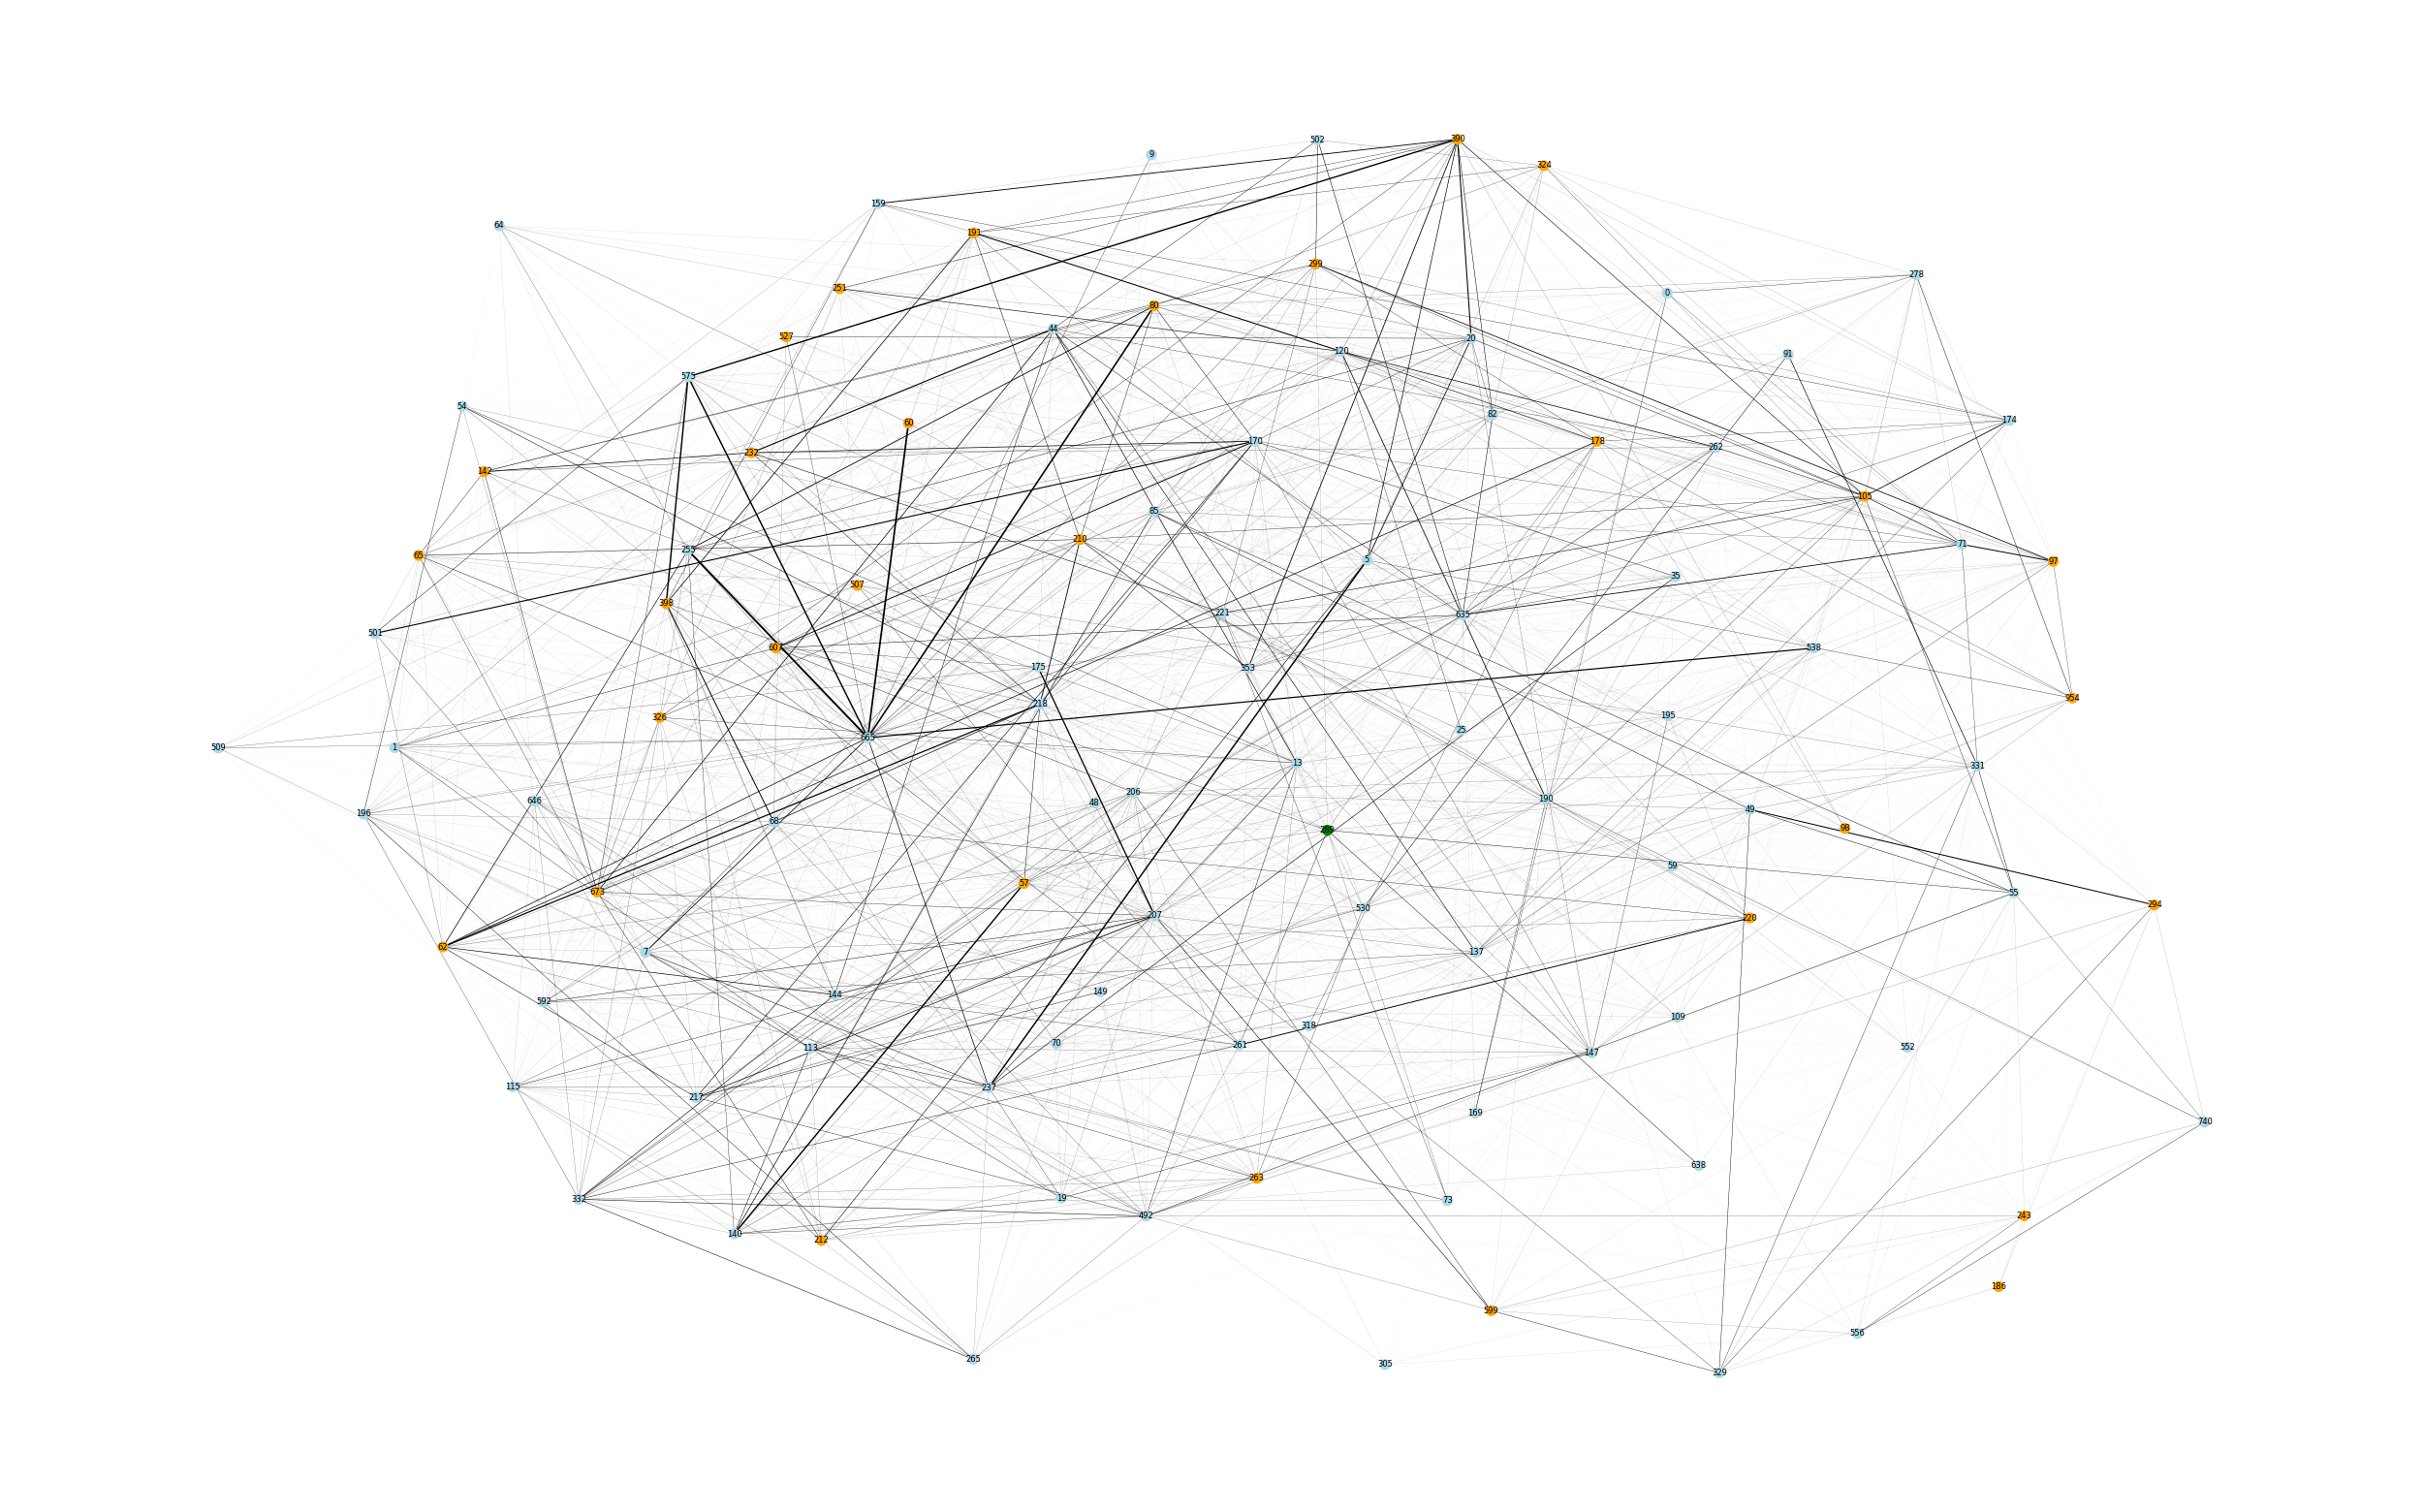

In [164]:
widths = np.array([w for *_, w in G_obs.edges.data('duration_frames')])

#pos = nx.shell_layout(G)
pos = nx.kamada_kawai_layout(G_obs)

# nodes
nx.draw_networkx_nodes(G_obs, pos, node_size=50, node_color=cols)

# edges
nx.draw_networkx_edges(G_obs, pos, width=widths/1200) 

# labels
nx.draw_networkx_labels(G_obs, pos, font_size=6, font_family="sans-serif")

#ax = plt.gca()
#ax.margins(0.08)
#plt.figure(figsize=(80, 60), dpi=500)
plt.axis("off")
#plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(32, 20)
fig.savefig('test1png.png', dpi=100)

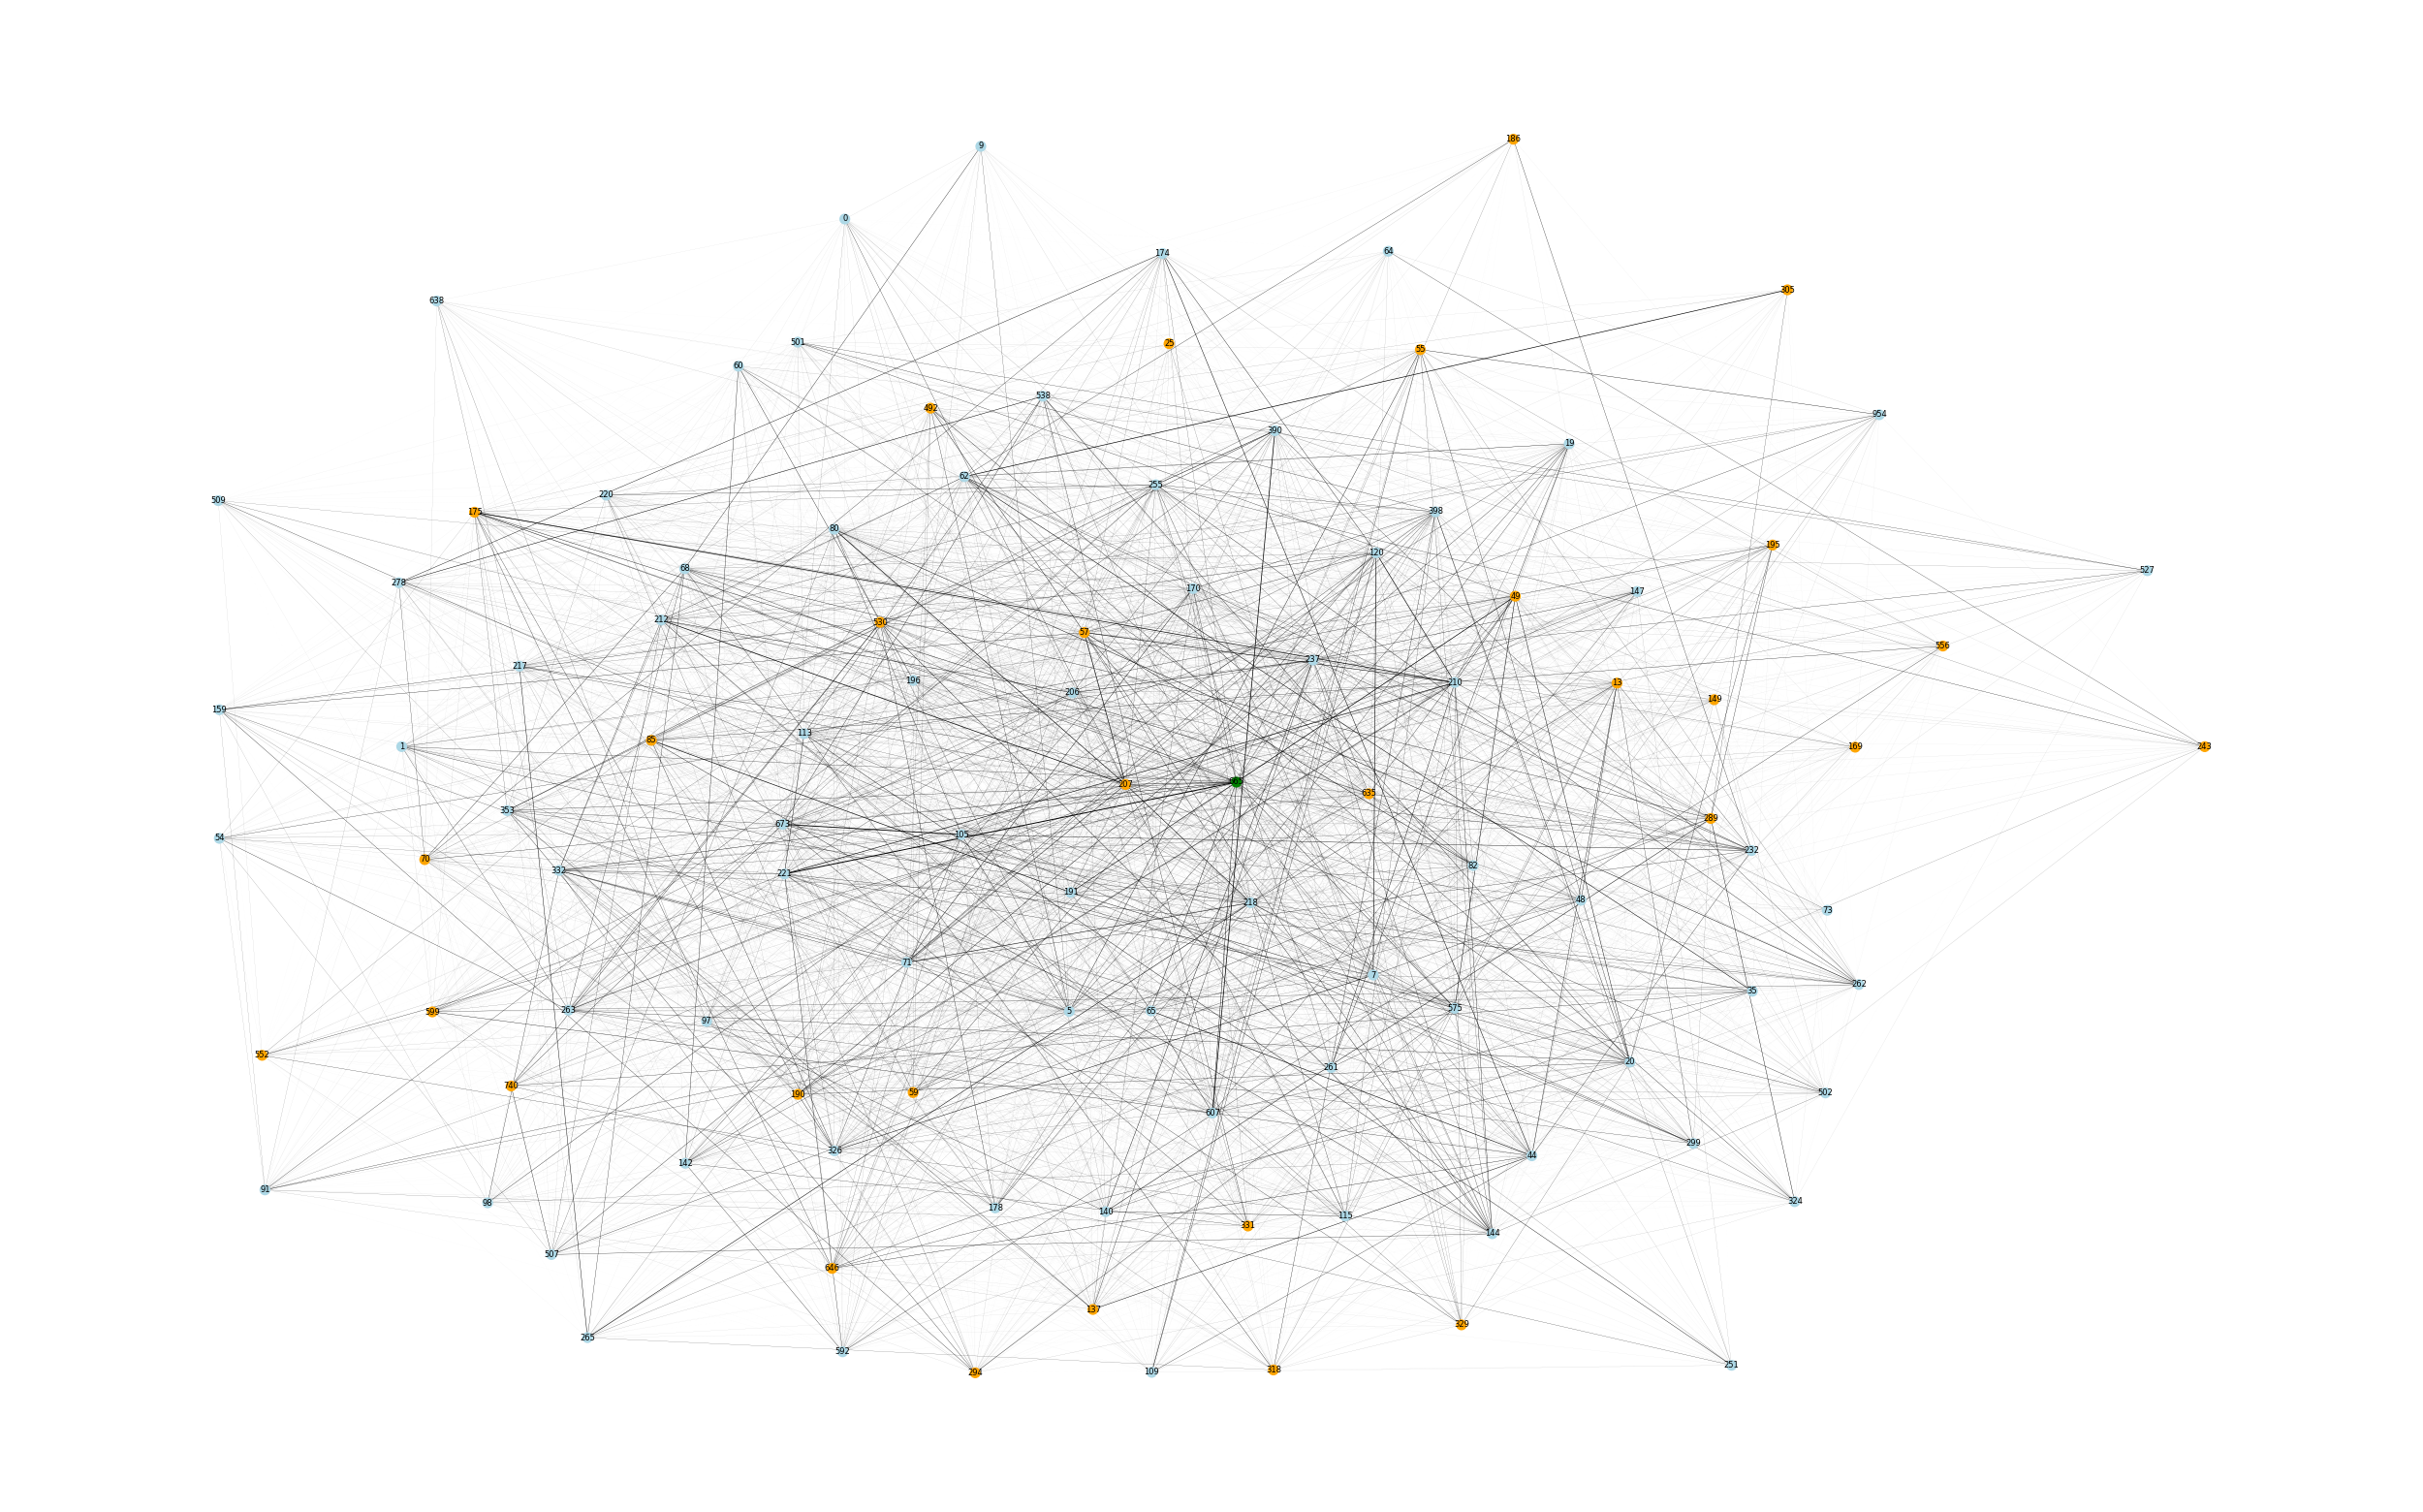

In [ ]:
widths = np.array([w for *_, w in G_rand.edges.data('duration_frames')])

#pos = nx.shell_layout(G)
pos = nx.kamada_kawai_layout(G_rand)

# nodes
nx.draw_networkx_nodes(G_rand, pos, node_size=50, node_color=cols)

# edges
nx.draw_networkx_edges(G_rand, pos, width=widths/1200) 

# labels
nx.draw_networkx_labels(G_rand, pos, font_size=6, font_family="sans-serif")

#ax = plt.gca()
#ax.margins(0.08)
#plt.figure(figsize=(80, 60), dpi=500)
plt.axis("off")
#plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(32, 20)
fig.savefig('test2png.png', dpi=100)

### Nepodstatne pripravy

In [146]:
n = 105
m_obs = sum(sum(obs_mat > 0))/2
m_rand = sum(sum(rand_mat > 0))/2

nurses = []
foragers = []
queen = []

for i in tags["tag"]:
    tag = tags.loc[tags["tag"] == i]["task_group"]
    if (tag == "nurse").all():
        nurses.append(i)
    elif (tag == "forager").all():
        foragers.append(i)
    elif (tag == "queen").all():
        queen.append(i)

### Hustota

In [132]:
print("Obsereved:", 2*m_obs/(n*(n-1)))
#print("Obsereved:", nx.density(G_obs))
print("Random:", 2*m_rand/(n*(n-1)))
#print("Random:", nx.density(G_rand))

Obsereved: 0.40073260073260075
Random: 0.6688644688644688


### Modularita

In [152]:
print("Observed:", nx.community.modularity(G_obs, [nurses, foragers, queen]))
print("Random:", nx.community.modularity(G_rand, [nurses, foragers, queen]))

Observed: 0.06030097273143527
Random: -0.0023485983163960586


### Priemerný stupeň vrcholu

In [153]:
print("Observed:",m_obs/n)
print("Random:",m_rand/n)

Observed: 20.83809523809524
Random: 34.78095238095238


##### Lepšie šírenie v randomizovanej 
##### Dôvody:
##### 1. vyšší stupeň vrchola a hustota -> chori jedinec môže chorobu rozniesť na viac ďalších
##### 2. záporná (nižšia) modularita -> vyšší počet stretnutí medzi skupinami (až do bodu, že skupiny takmer neexistujú) čiže choroba neostáva uzavretá hlavne v skupine